In [1]:
from evaluate_decoder import *

from quantum_error_correction_code import SurfaceCode
from neural_network import CNNDual, CNNDecoder, load_params

from jax import random
import jax.numpy as jnp

key = random.key(42)

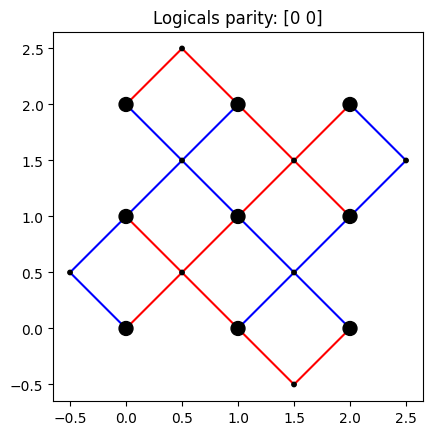

In [2]:
code = SurfaceCode(3)

deformation, key = code.random_deformation(key, allowed_deformations=jnp.array([0]))

parity_info = code.deformation_parity_info(deformation)

deformation_image = code.deformation_image(deformation)

code.show(parity_info)

In [3]:
batch_size = 32
error_probs = jnp.array([1E-5, 1E-5, 1E-2])

# Test data function

In [4]:
syndromes, logicals = data_batch(
    key,
    code,
    batch_size,
    parity_info,
    error_probs,
    as_images=True
)
syndromes.shape

(32, 4, 4)

# Test evaluation function on the PML decoder

In [5]:
evaluate_pml_decoder(
    key,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs
)

(Array(0.0017228, dtype=float32),
 Array([[9151512,     526,       0,       0],
        [  16670,  829457,       0,       0],
        [      1,       0,     875,      10],
        [      0,       0,      21,     928]], dtype=int32))

# Test evaluation function on the MWPM decoder

In [6]:
evaluate_mwpm_decoder(
    key,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs
)

(Array(0.0017236, dtype=float32),
 Array([[9151512,     526,       0,       0],
        [  16670,  829457,       0,       0],
        [      1,       0,     858,       1],
        [      0,       0,      38,     937]], dtype=int32))

# Test evaluation function on a mCNN decoder

In [7]:
settings, model_params = load_params("../data/CNN-G-3.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(1, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

In [8]:
evaluate_cnn_decoder(
    key,
    decoder_model,
    model_params,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs,
    deformation_image=deformation_image,
)

(Array(0.001765, dtype=float32),
 Array([[9153124,     524,     369,       0],
        [  16601,  827917,       0,       6],
        [      0,       0,     495,     118],
        [      0,       0,      32,     814]], dtype=int32))

# Test evaluation function on a CNN decoder

In [9]:
settings, model_params = load_params("../data/CNN-3-000000000.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDecoder(
    input_shape = (1, L+1, L+1),
    conv_layers = [tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS"]],
    fc_layers = [int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN': [(1, 4, 4), (8, 3, 3), (8, 2, 2)], 'MLP': [32, 50, 2]}

In [10]:
evaluate_cnn_decoder(
    key,
    decoder_model,
    model_params,
    code,
    deformation,
    batch_count=10,
    batch_size=1_000_000,
    error_probs=error_probs,
)

(Array(0.0017276, dtype=float32),
 Array([[9153123,     524,       3,       2],
        [  16601,  827917,       4,       4],
        [      1,       0,     852,     100],
        [      0,       0,      37,     832]], dtype=int32))